# Neural Network

## Importing Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics as metrics
from sklearn.model_selection import train_test_split 

from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.metrics import roc_curve, auc
import seaborn as sns

In [3]:
import numpy.random as r # We will randomly initialize our weights
from sklearn.metrics import accuracy_score # 

In [4]:
# import pandas as pd
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense
# from scikeras.wrappers import KerasClassifier
# from sklearn.model_selection import cross_val_score
# from sklearn.preprocessing import LabelEncoder
# from sklearn.model_selection import StratifiedKFold
# from sklearn.preprocessing import StandardScaler
# from sklearn.pipeline import Pipeline
# import keras
# from keras.models import Sequential
# from keras.layers import Dense
# from keras.layers import LeakyReLU,PReLU,ELU
# from keras.layers import Dropout

## Loading Dataset

In [5]:
df = pd.read_csv('heart.csv')
data = df.to_numpy()

In [6]:
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [7]:
X = data[:, :-1]
# y = data[:, -1]
y = data[:, -1].reshape((-1,1))

We split the data into training and test data sets. We will train the neural network with the training dataset, and evaluate our neural network with the test dataset

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

In [9]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train shape:", y_train.shape)
print("y_test shape:", y_test.shape)

X_train shape: (181, 13)
X_test shape: (122, 13)
y_train shape: (181, 1)
y_test shape: (122, 1)


In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Implementation Of Neural Network Using Pytorch

In [11]:
%conda install -c pytorch pytorch torchvision

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 23.7.4
  latest version: 24.3.0

Please update conda by running

    $ conda update -n base -c defaults conda

Or to minimize the number of packages updated during conda update use

     conda install conda=24.3.0



# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [12]:
import numpy as np
import torch
from torch import nn
from torch.nn import Linear, BCELoss
from torch.optim import SGD
import matplotlib.pyplot as plt

In [13]:
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train)

In [14]:
class model(nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(model, self).__init__()
        self.linear1 = Linear(n_feature, n_hidden, bias=True)
        self.linear2 = Linear(n_hidden, n_output, bias=True)
 
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        return x

In [15]:
my_model = model(X_train.shape[1], 8, 1)

In [16]:
loss_cal = BCELoss(reduction='mean')

In [17]:
optimizer = SGD(my_model.parameters(), lr=0.01)

In [18]:
epoch_list = []
loss_list = []
 
for epoch in range(10000):
    epoch_list.append(epoch)
    y_pred = my_model(X_train_tensor)
    loss = loss_cal(y_pred, y_train_tensor)
    loss_list.append(loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


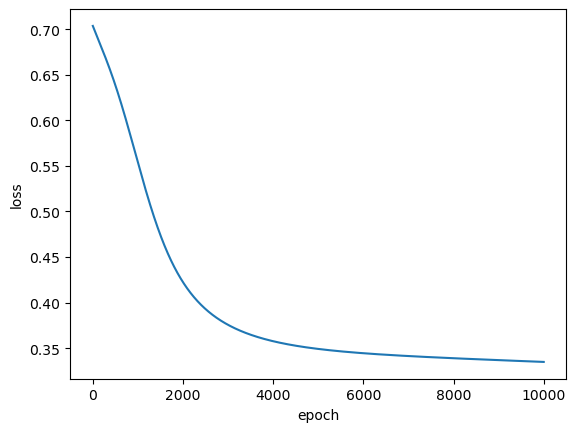

In [19]:
plt.figure()
plt.plot(epoch_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [20]:
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

In [21]:
y_pred_test = my_model(X_test_tensor)
y_pred_test_hard = torch.where(y_pred_test > 0.5, 1, 0)
correct = torch.where(y_pred_test_hard == y_test_tensor, 1, 0)
accuracy = float(torch.sum(correct) / y_test.shape[0])
print("accuracy:", accuracy)

accuracy: 0.8524590134620667


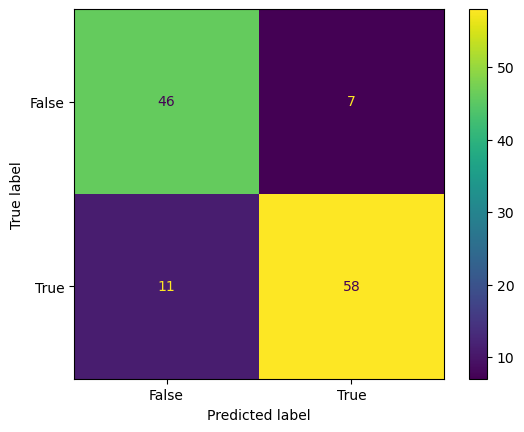

In [22]:
cm = metrics.confusion_matrix(y_test, y_pred_test_hard)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()

### Adding Regularization

In [23]:
optimizer_reg = SGD(my_model.parameters(), lr=0.01, weight_decay = 1e-2)

In [24]:
epoch_list = []
loss_list = []
 
for epoch in range(10000):
    epoch_list.append(epoch)
    y_pred = my_model(X_train_tensor)
    loss = loss_cal(y_pred, y_train_tensor)
    loss_list.append(loss.item())
    optimizer_reg.zero_grad()
    loss.backward()
    optimizer_reg.step()


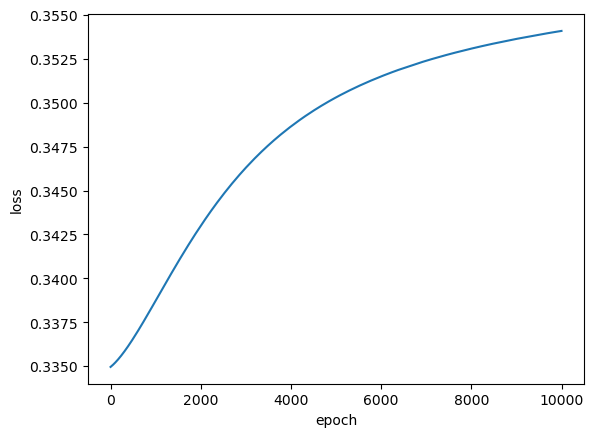

In [25]:
plt.figure()
plt.plot(epoch_list, loss_list)
plt.xlabel("epoch")
plt.ylabel("loss")
plt.show()

In [26]:
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test)

In [27]:
y_pred_test = my_model(X_test_tensor)
y_pred_test_hard = torch.where(y_pred_test > 0.5, 1, 0)
correct = torch.where(y_pred_test_hard == y_test_tensor, 1, 0)
accuracy = float(torch.sum(correct) / y_test.shape[0])
print("accuracy:", accuracy)

accuracy: 0.8524590134620667


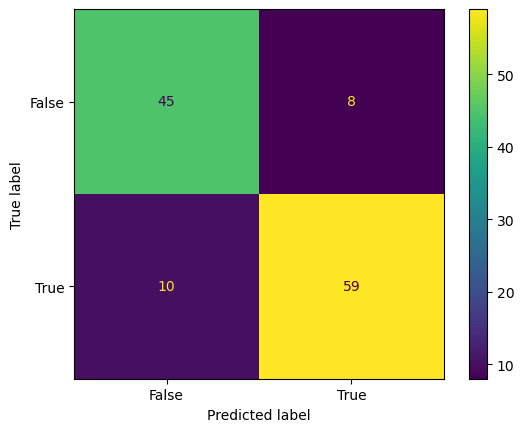

In [28]:
cm = metrics.confusion_matrix(y_test_tensor, y_pred_test_hard)
cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = [False, True])
cm_display.plot()
plt.show()